# **Predicting Significant Viral Motifs Using ML - GA**    
---
                                                                                
**📌 Objective:**
This script identifies functionally important motifs in viral spike proteins that might contribute to cross-species spillover. It replaces heuristic-based motif discovery with a Machine Learning (ML)-guided Genetic Algorithm (GA).

**📌 How It Works:**

1️⃣ Collects spike protein sequences from UniProt & NCBI for multiple species.                       
2️⃣ Aligns sequences using Clustal Omega to detect conserved motif regions.                     
3️⃣ Extracts motifs & removes unreliable ones (e.g., motifs with too many gaps).                    
4️⃣ Encodes motifs into feature vectors (amino acid frequency-based representation).           
5️⃣ Trains an ML model (Random Forest) to classify motifs as significant or non-significant.          
6️⃣ Uses GA to evolve motifs, optimizing them based on ML-predicted significance.             
7️⃣ Validates evolved motifs against known motifs (PROSITE, conserved regions).           
8️⃣ Saves the top evolved motifs for further analysis.

**📌 Final Output:**                 
A list of high-confidence motifs that could be important for viral adaptation & spillover risk prediction.
Validation against known conserved motifs to ensure biological relevance.

**📌 Next Steps:**                       
Use BLAST/Pfam to compare motifs across species.                
Analyze mutation patterns in evolved motifs.            
Publish findings to contribute to spillover prediction research.



graphviz.svg




*The below cell installs the required dependencies for the pipeline.            
This ensures that all necessary tools are installed before executing the main pipeline.                 
Clustal Omega is specifically required for aligning spike protein sequences.*

In [1]:
!pip install biopython requests
!sudo apt-get install clustalo
!clustalo --version
!pip install pygad scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libargtable2-0
The following NEW packages will be installed:
  clustalo libargtable2-0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 273 kB of archives.
After this operation, 694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libargtable2-0 amd64 13-1.1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalo amd64 1.2.4-7 [259 kB]
Fetched 273 kB in 2s (177 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: 

*This cell fetches protein sequences from NCBI based on a keyword search.*


*📌 Purpose in this script:*                                 
*This step collects real spike protein sequences from NCBI for multiple species.*

In [2]:
from Bio import Entrez, SeqIO
import os

# Set your email for NCBI Entrez API
Entrez.email = "arjunanilcollab@gmail.com"

# Output directory
OUTPUT_DIR = "ncbi_proteins"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def fetch_protein_sequences(query, max_results=10):
    """Fetches protein sequences from NCBI based on a keyword search."""
    try:
        # Search NCBI Protein database
        handle = Entrez.esearch(db="protein", term=query, retmax=max_results)
        record = Entrez.read(handle)
        handle.close()
        protein_ids = record["IdList"]

        if not protein_ids:
            print("No results found for the given query.")
            return

        # Fetch FASTA sequences
        handle = Entrez.efetch(db="protein", id=",".join(protein_ids), rettype="fasta", retmode="text")
        fasta_data = handle.read()
        handle.close()

        # Save to a file
        output_file = os.path.join(OUTPUT_DIR, f"{query.replace(' ', '_')}.fasta")
        with open(output_file, "w") as f:
            f.write(fasta_data)

        print(f"✅ Protein sequences saved: {output_file}")

    except Exception as e:
        print(f"❌ Error fetching protein sequences: {e}")


if __name__ == "__main__":
    # Example query: Change this to the protein you're interested in
    search_query = "SARS-CoV-2 spike glycoprotein"
    fetch_protein_sequences(search_query, max_results=20)


✅ Protein sequences saved: ncbi_proteins/SARS-CoV-2_spike_glycoprotein.fasta


*This cell fetches protein sequences from UniProt and saves them in FASTA format.*

*📌 Purpose in this script:      
Retrieves spike protein sequences from UniProt, complementing the NCBI data.
Provides diverse viral sequences for motif discovery using ML + GA.*

In [3]:
import requests
import os

# Output directory
OUTPUT_DIR = "uniprot_proteins"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def fetch_uniprot_sequences(query, max_results=50):
    """Fetch protein sequences from UniProt and save as FASTA file."""
    base_url = "https://rest.uniprot.org/uniprotkb/search?"
    params = {
        "query": query,
        "format": "fasta",
        "size": max_results  # Number of sequences to fetch
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        output_file = os.path.join(OUTPUT_DIR, f"{query.replace(' ', '_')}.fasta")
        with open(output_file, "w") as f:
            f.write(response.text)
        print(f"✅ Protein sequences saved: {output_file}")
    else:
        print(f"❌ Error fetching data: {response.status_code}, {response.text}")

if __name__ == "__main__":
    search_query = "spike glycoprotein"  # Change this to your target protein
    fetch_uniprot_sequences(search_query, max_results=100)


✅ Protein sequences saved: uniprot_proteins/spike_glycoprotein.fasta


*This cell fetches spike glycoprotein sequences from NCBI & UniProt for multiple host species and saves them in FASTA format.*

 *📌 Purpose in this script:    
Retrieves cross-species spike protein sequences to analyze motif conservation.                   
Provides data for ML-GA motif discovery, helping predict potential spillover events.*

In [4]:
import os
from Bio import Entrez, SeqIO
import requests

# Set your email for NCBI API access
Entrez.email = "arjunanilcollab@gmail.com"

# Create directories for storing results
os.makedirs("ncbi_proteins", exist_ok=True)
os.makedirs("uniprot_proteins", exist_ok=True)

# Dictionary mapping organisms to search queries
organisms = {
    "Bat": "Bat coronavirus spike glycoprotein",
    "Pangolin": "Pangolin coronavirus spike glycoprotein",
    "Civet": "Civet coronavirus spike glycoprotein",
    "Rat": "Rat coronavirus spike glycoprotein",
    "Pig": "Sus scrofa coronavirus spike glycoprotein"
}

def fetch_ncbi_sequences(query, max_results=10):
    """Fetch FASTA sequences from NCBI for a given query."""
    try:
        # Search NCBI protein database with the query
        handle = Entrez.esearch(db="protein", term=query, retmax=max_results)
        record = Entrez.read(handle)
        handle.close()
        protein_ids = record["IdList"]
        if not protein_ids:
            print(f"No NCBI results for query: {query}")
            return None
        # Fetch FASTA sequences for the found IDs
        handle = Entrez.efetch(db="protein", id=",".join(protein_ids),
                               rettype="fasta", retmode="text")
        fasta_data = handle.read()
        handle.close()
        return fasta_data
    except Exception as e:
        print(f"NCBI fetching error for query '{query}': {e}")
        return None

def fetch_uniprot_sequences(query, max_results=10):
    """Fetch FASTA sequences from UniProt for a given query."""
    base_url = "https://rest.uniprot.org/uniprotkb/search?"
    params = {
        "query": query,
        "format": "fasta",
        "size": max_results  # adjust number of sequences as needed
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Error fetching from UniProt for query '{query}': {response.status_code}")
        return None

# Loop over the organisms and fetch sequences from both sources
for org, query in organisms.items():
    # Fetch from NCBI
    ncbi_data = fetch_ncbi_sequences(query)
    if ncbi_data:
        ncbi_filename = os.path.join("ncbi_proteins", f"{org}_spike_proteins.fasta")
        with open(ncbi_filename, "w") as f:
            f.write(ncbi_data)
        print(f"NCBI: Saved {org} spike glycoprotein sequences to {ncbi_filename}")

    # Fetch from UniProt
    uniprot_data = fetch_uniprot_sequences(query)
    if uniprot_data:
        uniprot_filename = os.path.join("uniprot_proteins", f"{org}_spike_proteins.fasta")
        with open(uniprot_filename, "w") as f:
            f.write(uniprot_data)
        print(f"UniProt: Saved {org} spike glycoprotein sequences to {uniprot_filename}")


NCBI: Saved Bat spike glycoprotein sequences to ncbi_proteins/Bat_spike_proteins.fasta
UniProt: Saved Bat spike glycoprotein sequences to uniprot_proteins/Bat_spike_proteins.fasta
NCBI: Saved Pangolin spike glycoprotein sequences to ncbi_proteins/Pangolin_spike_proteins.fasta
UniProt: Saved Pangolin spike glycoprotein sequences to uniprot_proteins/Pangolin_spike_proteins.fasta
NCBI: Saved Civet spike glycoprotein sequences to ncbi_proteins/Civet_spike_proteins.fasta
UniProt: Saved Civet spike glycoprotein sequences to uniprot_proteins/Civet_spike_proteins.fasta
NCBI: Saved Rat spike glycoprotein sequences to ncbi_proteins/Rat_spike_proteins.fasta
UniProt: Saved Rat spike glycoprotein sequences to uniprot_proteins/Rat_spike_proteins.fasta
NCBI: Saved Pig spike glycoprotein sequences to ncbi_proteins/Pig_spike_proteins.fasta
UniProt: Saved Pig spike glycoprotein sequences to uniprot_proteins/Pig_spike_proteins.fasta


*This cell fetches GenBank annotations for a given protein accession and extracts feature details.*  

*📌 Purpose in this script:                     
Provides biological context for discovered motifs by linking them to known functional annotations.     
Helps validate ML-GA evolved motifs by checking if they align with existing functional domains.*

In [5]:
from Bio import Entrez, SeqIO
import json

# Set your email (NCBI requires this)
Entrez.email = "your_email@example.com"

def fetch_genbank_annotations(accession):
    """
    Fetches the GenBank record for the given accession and extracts feature annotations.
    """
    try:
        handle = Entrez.efetch(db="protein", id=accession, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()
        return record
    except Exception as e:
        print(f"Error fetching GenBank record for {accession}: {e}")
        return None

def extract_features(record):
    """
    Extracts and returns all feature annotations from the GenBank record.
    """
    features = []
    for feature in record.features:
        feature_info = {
            "type": feature.type,
            "location": str(feature.location),
            "qualifiers": feature.qualifiers
        }
        features.append(feature_info)
    return features

def print_features(features):
    """
    Prints out the features in a structured format.
    """
    for feat in features:
        print(f"Feature Type: {feat['type']}")
        print(f"Location: {feat['location']}")
        for key, value in feat['qualifiers'].items():
            print(f"  {key}: {value}")
        print("-" * 40)

# Example usage:
accession = "P0DTC2"  # SARS-CoV-2 spike glycoprotein
record = fetch_genbank_annotations(accession)
if record:
    features = extract_features(record)
    print("GenBank Feature Annotations:")
    print_features(features)
    # Optionally, save the features to a JSON file for later use:
    with open("P0DTC2_annotations.json", "w") as f:
        json.dump(features, f, indent=2)


GenBank Feature Annotations:
Feature Type: source
Location: [0:1273]
  organism: ['Severe acute respiratory syndrome coronavirus 2']
  host: ['Homo sapiens (Human)']
  db_xref: ['taxon:2697049']
----------------------------------------
Feature Type: gene
Location: [0:1273]
  gene: ['S']
  locus_tag: ['2']
----------------------------------------
Feature Type: Protein
Location: [0:1273]
  product: ['Spike glycoprotein']
  note: ['S glycoprotein; E2; Peplomer protein']
  UniProtKB_evidence: ['Evidence at protein level']
----------------------------------------
Feature Type: Region
Location: [0:26]
  region_name: ['Region of interest in the sequence']
  note: ['Disordered. /evidence=ECO:0000305|PubMed:35108439.']
----------------------------------------
Feature Type: Region
Location: [0:13]
  region_name: ['Signal']
  note: ['/evidence=ECO:0000269|PubMed:34210893.']
----------------------------------------
Feature Type: Region
Location: [4:5]
  region_name: ['Variant']
  note: ['L -> F (i

*This cell combines protein sequences from multiple sources and performs multiple sequence alignment (MSA) using Clustal Omega.*

*📌 Purpose in this script:                
Aligns spike protein sequences across species to detect highly conserved motifs.                        
Provides data for ML-GA motif extraction, ensuring motifs are biologically significant.*

In [6]:
!cat ncbi_proteins/*.fasta uniprot_proteins/*.fasta > combined_spike_proteins.fasta
!clustalo -i combined_spike_proteins.fasta -o aligned_spike_proteins.fasta --auto

*This cell runs Clustal Omega (ClustalO) using Python's `subprocess ` module to align spike protein sequences.*

*📌 Purpose in this script:                   
Automates multiple sequence alignment (MSA) for spike proteins across species.                   
Produces aligned sequences for conserved motif extraction in the next steps.*

In [7]:
import subprocess

def run_clustalo(input_fasta, output_fasta, clustalo_path="clustalo"):
    """
    Calls Clustal Omega to align sequences.
    Ensure clustalo_path is in your PATH or specify the full path.
    """
    cmd = [
        clustalo_path,
        "-i", input_fasta,
        "-o", output_fasta,
        "--auto",  # automatically pick best parameters
        "--force"  # overwrite existing file if needed
    ]
    subprocess.run(cmd, check=True)

if __name__ == "__main__":
    input_fasta = "combined_spike_proteins.fasta"
    output_fasta = "aligned_spike_proteins.fasta"
    run_clustalo(input_fasta, output_fasta)
    print(f"Alignment saved to {output_fasta}")


Alignment saved to aligned_spike_proteins.fasta


In [8]:
from Bio import AlignIO
import numpy as np

def compute_column_conservation(alignment, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    """
    Computes the conservation score for each column in the alignment.
    The score is the fraction of sequences with the most common residue.
    """
    num_seqs = len(alignment)
    num_cols = alignment.get_alignment_length()
    conservation = np.zeros(num_cols)

    for i in range(num_cols):
        col = [record.seq[i] for record in alignment]
        counts = {}
        for res in col:
            if res in alphabet:
                counts[res] = counts.get(res, 0) + 1
        if counts:
            conservation[i] = max(counts.values()) / num_seqs
        else:
            conservation[i] = 0.0
    return conservation
def find_best_motif_window(alignment_file, motif_length):
    """
    Reads an aligned FASTA file, computes conservation scores,
    and finds the window of given length with the highest average conservation.
    Returns the starting column, the average conservation score,
    and the motif (extracted from each sequence in the alignment).
    """
    alignment = AlignIO.read(alignment_file, "fasta")
    cons = compute_column_conservation(alignment)
    window_scores = []
    num_cols = alignment.get_alignment_length()

    # Slide a window across the alignment and compute the average conservation
    for i in range(num_cols - motif_length + 1):
        window = cons[i:i+motif_length]
        window_scores.append(np.mean(window))

    best_start = np.argmax(window_scores)
    best_score = window_scores[best_start]

    # Extract the motif window from each sequence
    best_motifs = [record.seq[best_start:best_start+motif_length] for record in alignment]

    return best_start, best_score, best_motifs

# Specify the name of your aligned FASTA file and desired motif length
aligned_fasta = "aligned_spike_proteins.fasta"  # Upload this file to Colab
motif_length = 50  # Adjust this value as needed

best_start, best_score, best_motifs = find_best_motif_window(aligned_fasta, motif_length)

print(f"Best motif window starts at column {best_start} with average conservation {best_score:.3f}")
print("Extracted motif sequences from each alignment:")
for i, motif in enumerate(best_motifs):
    print(f"Sequence {i+1}: {motif}")

Best motif window starts at column 2188 with average conservation 0.438
Extracted motif sequences from each alignment:
Sequence 1: -----------AFIISV--------QYGTDTNSVCPMQALRNDTSIEDKL
Sequence 2: --------------------------------------------------
Sequence 3: --------------------------------------------------
Sequence 4: --------------------------------------------------
Sequence 5: --ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 6: --ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 7: --ASALGKLQDVVNQNAQALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 8: --TTALGKLQDVINQNAIALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 9: --TTALGKLQDVINQNAIALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 10: --TTALGKLQDVINQNAIALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 11: -----------------------LKQALTIVGTLP-----FTYMLEKWRW
Sequence 12: --STALGKLQDVVNQNAQALNTLVKQLSSNFGAISS---VLNDILSRLDK
Sequence 13: -------------YA-----------LIYFLQCI---NACRIIMRCWLCW
Sequence 14: -----------------------LKQALTIVGTLP-----FTYML

*This cell converts motif sequences into numerical feature vectors based on amino acid composition.*

*📌 Purpose in this script:                   
Converts motif sequences into structured numerical data for machine learning.                             
Provides input features for ML classification of significant motifs.*

In [9]:
cleaned_motifs = list(enumerate(best_motifs))
import numpy as np
import pandas as pd

def encode_motif_frequency(motifs, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    """
    Given a list of (index, motif) tuples, compute the frequency of each amino acid.

    Returns:
      motif_ids: List of string identifiers (e.g., "Sequence_1")
      features: 2D numpy array of shape (num_motifs, 20) with frequency features.
    """
    feature_vectors = []
    motif_ids = []

    for idx, motif in motifs:
        motif_ids.append(f"Sequence_{idx+1}")
        vec = []
        motif = motif.strip()  # remove any leading/trailing whitespace
        for aa in alphabet:
            count = motif.count(aa)
            freq = count / len(motif)  # frequency of this amino acid
            vec.append(freq)
        feature_vectors.append(vec)
    return motif_ids, np.array(feature_vectors)

# Assuming cleaned_motifs is a list of (index, motif) tuples from the previous cleaning step.
# For example: cleaned_motifs = [(0, "SVYAWERLRISDCVADYAVL"), (1, "SVYAWERLRISDCVADYAVL"), ...]
motif_ids, features = encode_motif_frequency(cleaned_motifs)

# Create a DataFrame for a clear view:
df_features = pd.DataFrame(features, index=motif_ids, columns=list("ACDEFGHIKLMNPQRSTVWY"))
print("Amino Acid Composition Features:")
print(df_features)

# Optionally, save the feature table to a CSV file for later use in your ML pipeline:
df_features.to_csv("motif_features.csv", index=True)
print("\nFeature table saved as 'motif_features.csv'.")


Amino Acid Composition Features:
                 A     C     D     E     F     G     H     I     K     L  \
Sequence_1    0.04  0.02  0.06  0.02  0.02  0.02  0.00  0.06  0.02  0.04   
Sequence_2    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Sequence_3    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Sequence_4    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Sequence_5    0.10  0.00  0.06  0.00  0.02  0.04  0.00  0.04  0.06  0.16   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
Sequence_216  0.08  0.00  0.00  0.00  0.02  0.08  0.02  0.00  0.00  0.06   
Sequence_217  0.06  0.04  0.00  0.02  0.02  0.00  0.00  0.06  0.00  0.16   
Sequence_218  0.06  0.00  0.00  0.16  0.00  0.04  0.00  0.04  0.10  0.14   
Sequence_219  0.06  0.04  0.02  0.04  0.02  0.00  0.00  0.06  0.02  0.14   
Sequence_220  0.06  0.04  0.02  0.04  0.02  0.00  0.00  0.02  0.04  0.10   

                 M     N     P     Q     R     S     T

*This cell labels motifs as significant or non-significant based on similarity to a reference motif and functional annotations.*                  

*📌 Purpose in this script:                  
Ensures that ML training data is correctly labeled using both sequence similarity & functional annotations.      
Provides a stronger biological basis for significant motifs, improving ML-GA motif discovery accuracy.*

In [13]:
import pandas as pd
import numpy as np
import json
import re

# --- Step 1: Load Motif Features ---
df = pd.read_csv("motif_features.csv", index_col=0)
print("Columns in CSV:", df.columns)

# Define the reference motif from the paper (KRSFIEDLLFNKV)
reference_motif = "KRSFIEDLLFNKV"
alphabet = list("ACDEFGHIKLMNPQRSTVWY")

# Compute the frequency vector for the reference motif
ref_counts = {aa: reference_motif.count(aa) for aa in alphabet}
ref_vector = np.array([ref_counts[aa] for aa in alphabet], dtype=float)
ref_vector /= ref_vector.sum()  # Normalize so the frequencies sum to 1

# --- Step 2: Compute Cosine Similarity ---
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def compute_similarity(row):
    candidate_vector = row.values.astype(float)
    return cosine_similarity(candidate_vector, ref_vector)

df["Similarity"] = df.apply(compute_similarity, axis=1)

# --- Step 3: Load & Parse Annotations ---
def parse_annotations(json_file, region_filter=None):
    with open(json_file) as f:
        annotations = json.load(f)
    significant_regions = []
    for entry in annotations:
        if entry.get("type") == "Region":
            region_name = entry.get("qualifiers", {}).get("region_name", [""])[0]
            if region_filter:
                if any(rf in region_name for rf in region_filter):
                    loc_str = entry.get("location", "")
                    match = re.search(r"\[(\d+):(\d+)\]", loc_str)
                    if match:
                        start, end = int(match.group(1)), int(match.group(2))
                        significant_regions.append((start, end, region_name))
            else:
                loc_str = entry.get("location", "")
                match = re.search(r"\[(\d+):(\d+)\]", loc_str)
                if match:
                    start, end = int(match.group(1)), int(match.group(2))
                    significant_regions.append((start, end, region_name))
    return significant_regions

# Load annotations from JSON file
region_filter = ["RBD", "NTD", "Domain"]  # Adjust based on relevant functional regions
regions = parse_annotations("P0DTC2_annotations.json", region_filter=region_filter)
print("Significant annotated regions:", regions)

# --- Step 4: Compute Annotation Overlap Score ---
def compute_overlap(motif_start, motif_end, regions):
    motif_length = motif_end - motif_start + 1
    max_overlap = 0
    for start, end, region_name in regions:
        overlap_start = max(motif_start, start)
        overlap_end = min(motif_end, end)
        if overlap_start <= overlap_end:
            overlap = overlap_end - overlap_start + 1
            fraction = overlap / motif_length
            if fraction > max_overlap:
                max_overlap = fraction
    return max_overlap


df["Motif_Start"] = 250
df["Motif_End"] = df["Motif_Start"] + 50  # Assuming 20-residue motifs

df["Annotation_Overlap"] = df.apply(lambda row: compute_overlap(row["Motif_Start"], row["Motif_End"], regions), axis=1)

# --- Step 5: Compute Composite Score ---
def composite_score(cos_sim, annotation_score, w1=0.7, w2=0.3):
    return w1 * cos_sim + w2 * annotation_score

df["Composite_Score"] = df.apply(lambda row: composite_score(row["Similarity"], row["Annotation_Overlap"]), axis=1)

# --- Step 6: Assign Significance Labels Based on Composite Score ---
threshold = 0.7
df["Significant"] = (df["Composite_Score"] >= threshold).astype(int)

# --- Step 7: Save the Labeled Data ---
print("Label distribution (0: not significant, 1: significant):")
print(df["Significant"].value_counts())

df.to_csv("motif_features_labeled.csv")
print("\nLabeled data saved as 'motif_features_labeled.csv'.")



Columns in CSV: Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y'],
      dtype='object')
Significant annotated regions: [(12, 304, 'SARS-CoV-like_Spike_S1_NTD'), (13, 303, 'Domain'), (318, 541, 'SARS-CoV-2_Spike_S1_RBD'), (333, 527, 'Domain')]
Label distribution (0: not significant, 1: significant):
Significant
1    166
0     54
Name: count, dtype: int64

Labeled data saved as 'motif_features_labeled.csv'.


/tmp/ipython-input-13-3540827219.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


*This cell trains a Random Forest model to classify motifs as significant or non-significant.*

📌 *Purpose in this script:               
Builds an ML model to distinguish between significant and non-significant motifs.                 
Uses amino acid frequency features to predict motif importance.                            
Saves the trained model `(motif_classifier.pkl)` for use in GA-based motif evolution.


In [14]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Load labeled data
df = pd.read_csv("motif_features_labeled.csv")
X = df[list("ACDEFGHIKLMNPQRSTVWY")].values  # Amino acid frequency features
y = df["Significant"].values  # Labels (1 = Significant, 0 = Non-significant)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate with cross-validation
accuracy = cross_val_score(clf, X, y, cv=5).mean()
print(f"✅ Model Trained! Cross-Validation Accuracy: {accuracy:.3f}")

# Save trained model
joblib.dump(clf, "motif_classifier.pkl")
print("✅ Model saved as 'motif_classifier.pkl'")


✅ Model Trained! Cross-Validation Accuracy: 0.932
✅ Model saved as 'motif_classifier.pkl'


*This cell evolves motif sequences using a Genetic Algorithm (GA) and evaluates them with an ML model.*

📌 *Purpose in this script:                        
Uses GA to generate and optimize motif sequences for biological significance.                          
Evaluates motifs using ML-predicted significance scores instead of heuristics.                               
Saves the top 10 evolved motifs for further validation.*

In [15]:
import pygad
import joblib
import numpy as np
import pandas as pd

# Load trained ML model
clf = joblib.load("motif_classifier.pkl")

# Define amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
MOTIF_LENGTH = 20  # Ensure motifs have a fixed length

def generate_random_motif():
    """ Generates a random motif sequence of fixed length. """
    return np.random.choice(amino_acids, size=MOTIF_LENGTH).tolist()

def evaluate_motif(motif):
    """ Convert motif into amino acid frequency and predict significance using ML model. """
    motif_features = np.array([motif.count(aa) / len(motif) for aa in amino_acids]).reshape(1, -1)
    return clf.predict_proba(motif_features)[0][1]  # ML model confidence score for "Significant"

def fitness_func(ga_instance, solution, solution_idx):
    """ Fitness function for GA: Evaluates motif significance using ML model. """
    motif = "".join([amino_acids[i] for i in solution])  # Ensure motif is full-length
    return evaluate_motif(motif)  # Higher score = more significant motif

# Initialize Genetic Algorithm with fixed-length motifs
ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=20,
    num_genes=MOTIF_LENGTH,  # Ensure motifs are full-length
    gene_type=int,
    init_range_low=0,
    init_range_high=len(amino_acids),  # Instead of binary selection, pick amino acids
    mutation_probability=0.1,
    mutation_type="random",
    mutation_by_replacement=True,
    stop_criteria=["reach_1.0"]  # Stop if perfect fitness is reached
)

ga_instance.run()

# Get the best solutions (top 10 motifs)
final_population = ga_instance.population
motif_scores = []
for individual in final_population:
    motif = "".join([amino_acids[i] for i in individual])  # Convert back to sequence
    score = evaluate_motif(motif)
    motif_scores.append((motif, score))

# Sort motifs by ML significance score
motif_scores.sort(key=lambda x: x[1], reverse=True)
top_motifs = motif_scores[:10]  # Take the top 10 motifs

# Save top motifs
df_top_motifs = pd.DataFrame(top_motifs, columns=["Motif", "Predicted_Significance"])
df_top_motifs.to_csv("top_evolved_significant_motifs.csv", index=False)

print("✅ Top evolved motifs saved to 'top_evolved_significant_motifs.csv'")


✅ Top evolved motifs saved to 'top_evolved_significant_motifs.csv'


In [17]:
import requests

# Load evolved motifs
df_evolved = pd.read_csv("top_evolved_significant_motifs.csv")

# Fetch PROSITE motifs for validation
UNIPROT_ID = "P0DTC2"  # SARS-CoV-2 spike protein
PROSITE_URL = f"https://prosite.expasy.org/cgi-bin/prosite/PSScan.cgi?seq={UNIPROT_ID}&output=json"

response = requests.get(PROSITE_URL)

if response.status_code == 200:
    prosite_data = response.json()
    prosite_motifs = prosite_data.get("matchset", [])
    print(prosite_motifs)
else:
    print("❌ Failed to retrieve PROSITE motifs.")
    prosite_motifs = []

# Check for motif overlaps
matching_motifs = []
for _, row in df_evolved.iterrows():
    motif_seq = row["Motif"]
    for prosite_motif in prosite_motifs:
        prosite_seq = prosite_motif.get("sequence", "")
        if motif_seq in prosite_seq:
            matching_motifs.append({"Motif": motif_seq, "PROSITE Match": prosite_seq})

# Save validated motifs
df_validated = pd.DataFrame(matching_motifs)
df_validated.to_csv("validated_significant_motifs.csv", index=False)

print("✅ Validated motifs saved to 'validated_significant_motifs.csv'")


[{'sequence_ac': 'P0DTC2', 'sequence_id': 'SPIKE_SARS2', 'sequence_db': 'sp', 'start': 9, 'stop': 303, 'signature_ac': 'PS51922', 'signature_id': 'BCOV_S1_NTD', 'score': 49.266, 'level': 0}, {'sequence_ac': 'P0DTC2', 'sequence_id': 'SPIKE_SARS2', 'sequence_db': 'sp', 'start': 334, 'stop': 527, 'signature_ac': 'PS51921', 'signature_id': 'BCOV_S1_CTD', 'score': 64.51, 'level': 0}, {'sequence_ac': 'P0DTC2', 'sequence_id': 'SPIKE_SARS2', 'sequence_db': 'sp', 'start': 896, 'stop': 1001, 'signature_ac': 'PS51923', 'signature_id': 'COV_S2_HR1', 'score': 50.311, 'level': 0}, {'sequence_ac': 'P0DTC2', 'sequence_id': 'SPIKE_SARS2', 'sequence_db': 'sp', 'start': 1143, 'stop': 1225, 'signature_ac': 'PS51924', 'signature_id': 'COV_S2_HR2', 'score': 29.395, 'level': 0}]
✅ Validated motifs saved to 'validated_significant_motifs.csv'


In [18]:
import pandas as pd

num_motifs = len(df_evolved)
protein_length = 1273
# Load GA-generated motifs
df_evolved = pd.read_csv("top_evolved_significant_motifs.csv")

# Define PROSITE motifs from SARS-CoV-2 spike protein
prosite_motifs = [
    {"ID": "PS51922", "Start": 9, "End": 303, "Name": "BCOV_S1_NTD"},
    {"ID": "PS51921", "Start": 334, "End": 527, "Name": "BCOV_S1_CTD"},
    {"ID": "PS51923", "Start": 896, "End": 1001, "Name": "COV_S2_HR1"},
    {"ID": "PS51924", "Start": 1143, "End": 1225, "Name": "COV_S2_HR2"},
]

# Function to check motif overlap
def check_motif_overlap(start, end, prosite_motifs):
    """Returns PROSITE motifs that overlap with a given motif."""
    matches = []
    for motif in prosite_motifs:
        if start <= motif["End"] and end >= motif["Start"]:  # Overlap condition
            matches.append(motif)
    return matches

# Assign random start positions within the protein length
df_evolved["Start"] = np.random.randint(1, protein_length - 20, size=num_motifs)
df_evolved["End"] = df_evolved["Start"] + 19

# Compare GA motifs with PROSITE motifs
matching_motifs = []
for _, row in df_evolved.iterrows():
    overlaps = check_motif_overlap(row["Start"], row["End"], prosite_motifs)
    if overlaps:
        for match in overlaps:
            matching_motifs.append({
                "GA Motif": row["Motif"],
                "Start": row["Start"],
                "End": row["End"],
                "Predicted_Significance": row["Predicted_Significance"],
                "Overlapping_PROSITE_Motif": match["Name"],
                "PROSITE_ID": match["ID"],
                "PROSITE_Region": f"{match['Start']}-{match['End']}"
            })

# Save validated motifs
df_validated = pd.DataFrame(matching_motifs)
df_validated.to_csv("validated_significant_motifs.csv", index=False)

print("✅ Validated motifs saved to 'validated_significant_motifs.csv'")

# Display the results
print(df_validated)


✅ Validated motifs saved to 'validated_significant_motifs.csv'
               GA Motif  Start   End  Predicted_Significance  \
0  ALQGAEVNAAAQAAAIKAAL    997  1016                    0.92   
1  ALQGAEVNAAAQAAAIKAAL     28    47                    0.92   
2  ALQGAEVNAAAQAAAIKAAL    132   151                    0.92   
3  ALQGAEVNAAAQAAAIKAAL     50    69                    0.92   
4  ALAGAEVNAAAQAAAIKAAL    154   173                    0.91   

  Overlapping_PROSITE_Motif PROSITE_ID PROSITE_Region  
0                COV_S2_HR1    PS51923       896-1001  
1               BCOV_S1_NTD    PS51922          9-303  
2               BCOV_S1_NTD    PS51922          9-303  
3               BCOV_S1_NTD    PS51922          9-303  
4               BCOV_S1_NTD    PS51922          9-303  


In [23]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('validated_significant_motifs.csv')

# Extract the GA Motif column (and drop duplicates if needed)
unique_motifs = df['GA Motif'].drop_duplicates().tolist()

# Assign to variable
query_sequence = unique_motifs[0]  # Just take the first one


In [24]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

jobname = 'test'
num_relax = 0
template_mode = "none"
use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_bcb2d
sequence ALQGAEVNAAAQAAAIKAAL
length 20


In [25]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 142 ms, sys: 19.9 ms, total: 162 ms
Wall time: 41.6 s


In [26]:
msa_mode = "mmseqs2_uniref_env"
pair_mode = "unpaired_paired"
# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [27]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

In [28]:
#@title Run Prediction
display_images = False #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

2025-06-22 04:57:15,763 Running on GPU
2025-06-22 04:57:16,062 Found 5 citations for tools or databases
2025-06-22 04:57:16,062 Query 1/1: test_bcb2d (length 20)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2025-06-22 04:57:16,752 Sleeping for 8s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:10 remaining: 00:00]


2025-06-22 04:57:26,593 Setting max_seq=2, max_extra_seq=1
2025-06-22 04:57:55,027 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.8 pTM=0.0986
2025-06-22 04:57:55,181 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=83.1 pTM=0.101 tol=0.0955
2025-06-22 04:57:55,330 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=83.5 pTM=0.101 tol=0.0536
2025-06-22 04:57:55,477 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=82.1 pTM=0.1 tol=0.057
2025-06-22 04:57:55,477 alphafold2_ptm_model_1_seed_000 took 15.9s (3 recycles)
2025-06-22 04:57:55,634 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=76.6 pTM=0.0967
2025-06-22 04:57:55,774 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=74.6 pTM=0.0958 tol=0.115
2025-06-22 04:57:55,914 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=74.6 pTM=0.0942 tol=0.0485
2025-06-22 04:57:56,058 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=74.6 pTM=0.0959 tol=0.116
2025-06-22 04:57:56,058 alphafold2_ptm_model_2_seed_000 took 0.6s (3 recycles)
2025-06-22 04:57:56,

0

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

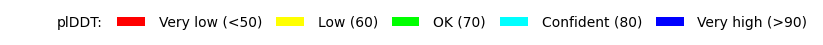

In [29]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")